In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import tensorflow.keras as keras
import os

#https://cienciadedatos.net/documentos/pygml01-introduccion-grafos-redes-python
import networkx as nx


2024-05-27 23:24:17.023469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 23:24:17.023500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 23:24:17.027114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 23:24:17.360028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Cargar imágenes

In [2]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'aspect_ratio': np.float32(w)/h, 
            'extent': np.float32(cv2.contourArea(contour))/rect_area,
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features


# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')
        
        ## Calcular el aspect ratio de los poros
        aspect_ratio = get_item(contour_features, key='aspect_ratio')

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro), np.mean(eq_diameter), np.mean(aspect_ratio), npores]
        
        descriptors.append(descriptor)
        
    
    return descriptors

# function to associate geometric atributes with images

def normalize_geometric_properties(dataset):

    ## Listas para guardar propiedades
    areas = []
    perimetros = []
    intersticios = []
    poros = []

    for i in range(len(dataset)):    
        
        ## obtener ruta de la imagen
        mask_route = dataset['route_mask'].to_numpy()[i]
        ## obtener imagen binaria
        mask = get_binary_image([mask_route])
        ## capturar propiedades
        atrs = get_geometric_atributes(mask)[0]

        ## agregar a listas las propiedades
        areas.append(atrs[0])
        perimetros.append(atrs[1])
        intersticios.append(atrs[2])
        poros.append(atrs[3])

    ## normalizar datos
        
    # normalizar area
    min_area = np.min(areas)
    max_area = np.max(areas)
    areas_norm = (areas - min_area) / (max_area - min_area)

    # normailizar perimetro
    min_perimetro = np.min(perimetros)
    max_perimetro = np.max(perimetros)
    perimetros_norm = (perimetros - min_perimetro) / (max_perimetro - min_perimetro)

    #normalizar intersticio
    min_intersticio = np.min(intersticios)
    max_intersticio = np.max(intersticios)
    intersticios_norm = (intersticios - min_intersticio) / (max_intersticio - min_intersticio)

    #normalizar poros
    min_poros = np.min(poros)
    max_poros = np.max(poros)
    poros_norm = (poros - min_poros) / (max_poros - min_poros)


    dataset['area'] = areas_norm
    dataset['perimetro'] = perimetros_norm
    dataset['intersticio'] = intersticios_norm
    dataset['poros'] = poros_norm


    return dataset, [min_area, min_perimetro, min_intersticio, min_poros], [max_area, max_perimetro, max_intersticio, max_poros]


## desnormalizar datos
def de_normalize_value(value, min_value, max_value):
    return (value * (max_value - min_value)) + min_value

## Reorganizar atributos geométricos
def organize_geometric_atributes(dataset):
    attributes = []
    for i in range(len(dataset)):
        attributes.append([dataset['area'].to_numpy()[i],dataset['perimetro'].to_numpy()[i],dataset['intersticio'].to_numpy()[i],dataset['poros'].to_numpy()[i]])

    return attributes

def split_dataset(routes_dataset):
    ## Establecer el porcentaje de separación
    thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
    thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
    thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

    ## Separar por clases para entrenamiento
    train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
    train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
    train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

    ## tomar las demás imágenes para test
    test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
    test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
    test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


    ## Constuir un solo dataset de training
    train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

    ## Construir un solo dataset de test
    test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

    ## Cantidad de muestras por clase
    print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
    print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
    print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

    return train_df, test_df


def create_dataset(buffer,dataset): 
  ## Get file names
  file_names = dataset['route_image'].to_numpy()
  ## Get labels
  labels = dataset['label'].to_numpy()
  ## Get geometric atributes from binary images
  attributes = organize_geometric_atributes(dataset)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

routes_dataset


,name,route_image,label,number,route_mask
714,IMG_20230711_180538_jpg,../../../Datasets/Micrografías segmentaciones/...,MF2,6,../../../Datasets/Micrografías segmentaciones/...
565,IMG_20230711_163225_jpg,../../../Datasets/Micrografías segmentaciones/...,MF2,3,../../../Datasets/Micrografías segmentaciones/...
705,IMG_20230711_180449_jpg,../../../Datasets/Micrografías segmentaciones/...,MF2,6,../../../Datasets/Micrografías segmentaciones/...
813,IMG_20230711_212248_jpg,../../../Datasets/Micrografías segmentaciones/...,MF3,7,../../../Datasets/Micrografías segmentaciones/...
222,IMG_20230707_170909_jpg,../../../Datasets/Micrografías segmentaciones/...,MF1,3,../../../Datasets/Micrografías segmentaciones/...
...,...,...,...,...,...
353,IMG_20230707_180855_jpg,../../../Datasets/Micrografías segmentaciones/...,MF1,5,../../../Datasets/Micrografías segmentaciones/...
460,IMG_20230707_191734_jpg,../../../Datasets/Micrografías segmentaciones/...,MF1,7,../../../Datasets/Micrografías segmentaciones/...
86,IMG_20230602_221704_jpg,../../../Datasets/Micrografías segmentaciones/...,MF3,4,../../../Datasets/Micrografías segmentaciones/...
176,IMG_20230707_164346_jpg,../../../Datasets/Micrografías segmentaciones/...,MF1,2,../../../Datasets/Micrografías segmentaciones/...


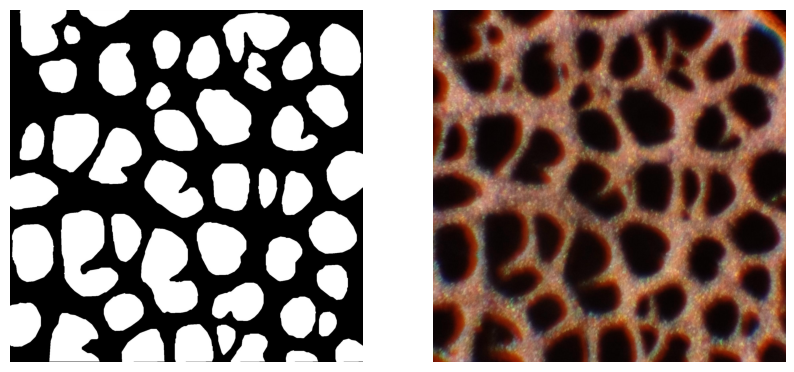

<Figure size 640x480 with 0 Axes>

In [4]:
## seleccionar una imagen aleatoria
idx = 0
mask_route = routes_dataset['route_mask'].to_numpy()[idx]
image_route = routes_dataset['route_image'].to_numpy()[idx]

## plot mascara y original
mask = cv2.imread(mask_route)
image = cv2.imread(image_route)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mask)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image)
plt.axis('off')
plt.show()
plt.tight_layout()

In [5]:
## Constuir una matriz de atributos geométricos de la imagen
mask = get_binary_image([mask_route])

## Calcular atributos geométricos
atrs = get_contours_and_features(mask[0].numpy().astype(np.uint8))

## lista con los poros
pores = []
for pore in atrs:
    ## centro de masa del poro
    cx = pore['center_of_mass'][0]
    cy = pore['center_of_mass'][1]
    ## area del poro
    area = pore['area']
    ## perimetro del poro
    perimeter = pore['perimeter']
    ## diametro equivalente del poro
    eq_diameter = pore['equivalent_diameter']

    pores.append([cx,cy,area,perimeter,eq_diameter])
    
## convertir a dataframe
pores_df = pd.DataFrame(pores,columns=['cx','cy','area','perimeter','eq_diameter'])


## extraer la localización de los poros en dataframe aparte
pores_location = pores_df[['cx','cy']]

## extraer features a parte
pores_features = pores_df[['area','perimeter','eq_diameter']]

2024-05-27 23:24:23.259897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 23:24:23.325612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 23:24:23.325809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

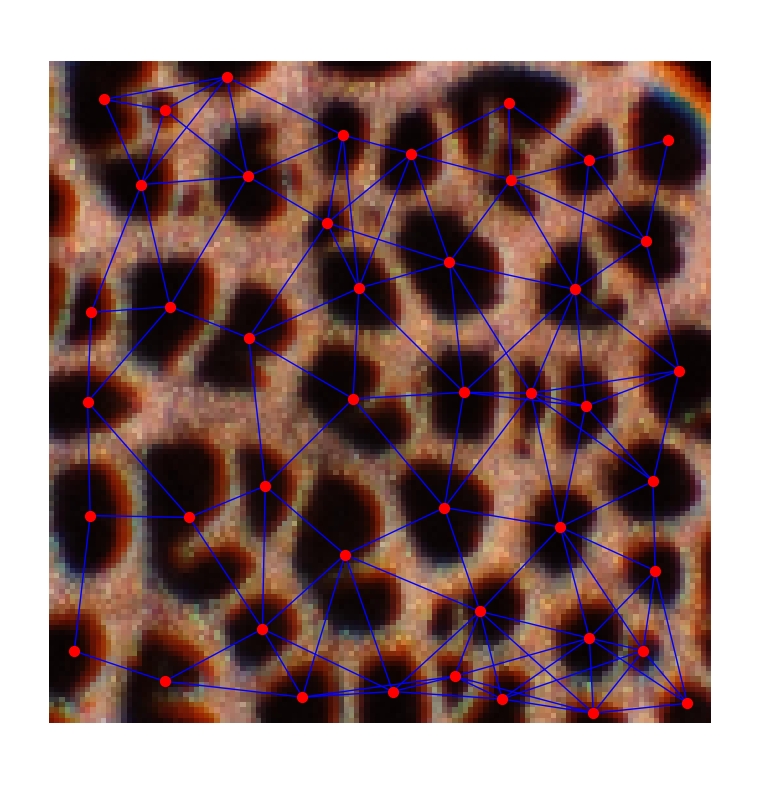

In [22]:
## crear grafo

## crear grafo
G = nx.Graph()

## añadir nodos definidos por su posición x,y
for i in range(len(pores_location)):
    ## node properties
    x = pores_location['cx'].to_numpy()[i]
    y = pores_location['cy'].to_numpy()[i]
    
    ## add node
    G.add_node(i,pos=(x,y))
    
## añadir aristas
max_distance = 30

for i in range(len(pores_location)):
    for j in range(i+1,len(pores_location)):
        ## distancia euclidiana
        distance = np.sqrt((pores_location['cx'].to_numpy()[i] - pores_location['cx'].to_numpy()[j])**2 + (pores_location['cy'].to_numpy()[i] - pores_location['cy'].to_numpy()[j])**2)
        if distance < max_distance and distance > 0:
            G.add_edge(i,j,weight=distance)
            
## dibujar grafo sobre la imagen original 
plt.figure(figsize=(10,10))
## redimensionar imagen para que se ajuste al grafo 128x128
image = cv2.resize(image,(128,128))
plt.imshow(image)
plt.axis('off')
## dibujar nodos
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos,node_size=50,node_color='red',with_labels=False,edge_color='blue')


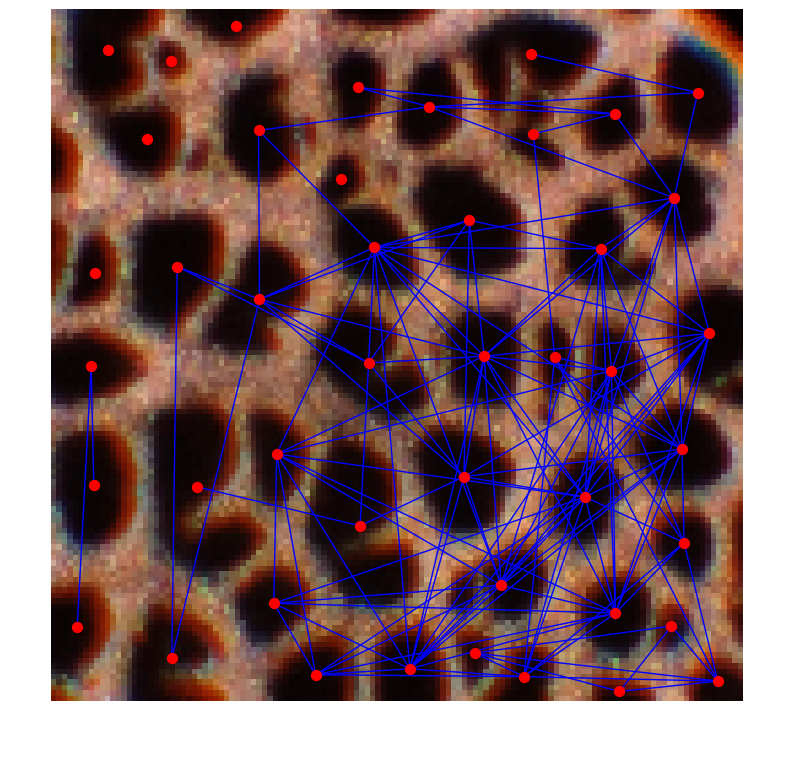

In [25]:
## Creación de grafos por proximiidad de los features de los poros
## crear grafo
G = nx.Graph()

## añadir nodos definidos por su posición x,y, y features
for i in range(len(pores_location)):
    ## node properties
    x = pores_location['cx'].to_numpy()[i]
    y = pores_location['cy'].to_numpy()[i]
    area = pores_features['area'].to_numpy()[i]
    perimeter = pores_features['perimeter'].to_numpy()[i]
    eq_diameter = pores_features['eq_diameter'].to_numpy()[i]
    
    ## add node
    G.add_node(i,pos=(x,y),area=area,perimeter=perimeter,eq_diameter=eq_diameter)

## función para calcular la similitud entre dos nodos
def get_similitud(node1,node2,similitud='euclidean'):
    ## extraer features
    features1 = [node1['area'],node1['perimeter'],node1['eq_diameter'],node1['pos'][0],node1['pos'][1]]
    features2 = [node2['area'],node2['perimeter'],node2['eq_diameter'],node2['pos'][0],node2['pos'][1]]
    ## calcular similitud
    if similitud == 'euclidean':
        sim = np.sqrt(np.sum((np.array(features1) - np.array(features2))**2))
    elif similitud == 'manhattan': 
        sim = np.sum(np.abs(np.array(features1) - np.array(features2)))
    elif similitud == 'dot_product':
        sim = np.dot(np.array(features1),np.array(features2))
    elif similitud == 'relative':
        features1 = np.array(features1)
        features2 = np.array(features2)
        sim = np.mean(((np.abs(features1-features2)/np.abs(features1)) + (np.abs(features2-features1)/np.abs(features2)))/2)
    else:
        sim = None
        
    return sim


## construir mamtrix de similitud entre nodos
sim_matrix = np.zeros((len(pores_location),len(pores_location)))
for i in range(len(pores_location)):
    for j in range(len(pores_location)):
        node1 = G.nodes[i]
        node2 = G.nodes[j] 
        sim_matrix[i,j] = get_similitud(node1,node2,similitud='relative')
        
 
sim_matrix = pd.DataFrame(sim_matrix)

## normalize sim_matrix
mean_sim = np.mean(sim_matrix.to_numpy())
std_sim = np.std(sim_matrix.to_numpy())

## umbral para establecer la conexión entre nodos
thold = 0.35

## añadir aristas a partir de la matriz de similitud
for i in range(len(pores_location)):
    for j in range(len(pores_location)):
        if sim_matrix.to_numpy()[i,j] < thold and i != j:
            G.add_edge(i,j,weight=sim_matrix.to_numpy()[i,j])

## dibujar grafo sobre la imagen original
plt.figure(figsize=(10,10))
## redimensionar imagen para que se ajuste al grafo 128x128
image = cv2.resize(image,(128,128))
plt.imshow(image)
plt.axis('off')
## dibujar nodos
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos,node_size=50,node_color='red',with_labels=False,edge_color='blue')